# Prod

In [ ]:
import os
from tqdm import tqdm
from PIL import Image
import pytesseract
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_text_splitters.base import Language
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.document_loaders import PyMuPDFLoader, TextLoader
from transformers import pipeline
from pdf2image import convert_from_path
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
import pymupdf
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt 


#Suppress tokenizer parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Specify the tessdata path
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"
os.environ["TESSDATA_PREFIX"] = "/opt/homebrew/share/tessdata"
tesseract_config = "--psm 12 --oem 2 -c textord_paragraph_text_based=0"

#Function to load and split data into chunks
def load_and_split_data(data_path):
    """
    Load and split data from a directory containing PDF, TXT, images, and code files.
    Apply Tesseract OCR for pages with no content extracted by PyMuPDFLoader.
    :param data_path: Path to the main dataset directory.
    :param tesseract_config: Custom configuration for Tesseract.
    :return: List of split chunks from all documents.
    """
    documents = []
    skipped_files = 0

    if os.path.isdir(data_path):
        for root, _, files in os.walk(data_path):
            for file in tqdm(files, desc="Processing files", unit="file"):
                file_path = os.path.join(root, file)
                ext = os.path.splitext(file)[1].lower()
                print(f"Processing file: {file_path}, Extension: {ext}")

                try:
                    if ext in [".pdf"]:
                        loader = PyMuPDFLoader(file_path)
                        loaded_documents = loader.load()

                        # Check each page for empty content
                        for doc in loaded_documents:
                            if not doc.page_content.strip():  # If the page content is empty
                                print(f"Empty page detected, applying OCR to page {doc.metadata.get('page', '?')} in {file_path}")
                                images = convert_from_path(file_path, first_page=doc.metadata["page"] + 1,
                                                           last_page=doc.metadata["page"] + 1,
                                                             poppler_path='/opt/homebrew/Cellar/poppler/25.01.0/bin')
                                ocr_text = "\n".join([pytesseract.image_to_string(img, config=tesseract_config, lang='eng') for img in images])
                                if ocr_text.strip():
                                    doc.page_content = ocr_text  # Update the page content with OCR result
                                else:
                                    print(f"No text found on page {doc.metadata['page'] + 1} of {file_path}")
                            documents.append(doc)

                    elif ext in [".png", ".jpg", ".jpeg"]:
                        print(f"Applying OCR to image: {file_path}")
                        text = pytesseract.image_to_string(Image.open(file_path))
                        if text.strip():
                            documents.append(Document(page_content=text, metadata={"source": file_path, "file_path": file_path, "page": 0, "total_pages": 1, "format": 'Image'}))
                    elif ext == ".txt":
                        loader = TextLoader(file_path)
                        documents.extend(loader.load())
                    elif ext == ".tex":
                        print(f"Processing Latex file: {file_path}")
                        latex_splitter = RecursiveCharacterTextSplitter.from_language(
                            language=Language.MARKDOWN, chunk_size=1000, chunk_overlap=20)
                        with open(file_path, "r", encoding="utf-8") as latex_file:
                            latex_content = latex_file.read()
                            latex_docs = latex_splitter.create_documents([latex_content], metadatas=[{"source": file_path, "file_path": file_path, "format": 'Latex'}])
                            for docs in latex_docs:
                                documents.append(docs)
                    else:
                        print(f"Unsupported file format: {file_path}")
                        skipped_files += 1
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    skipped_files += 1
    else:
        print(f"The path {data_path} is not a directory.")
        return []

    print(f"Number of documents before splitting: {len(documents)}")
    if not documents:
        print("No valid documents found.")
        return []

    print("Splitting documents into chunks...")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=150, 
                                                   separators=[ "\n\n"," ",".",",",])
    split_chunks = text_splitter.split_documents(documents)

    print(f"Number of chunks created: {len(split_chunks)}")
    print(f"Skipped files: {skipped_files}")
    return split_chunks

# Main pipeline setup
def build_rag_pipeline(data_path, embed_name="sentence-transformers/all-MiniLM-L6-v2", llm_model="google/flan-t5-large"):
    #Load and split data
    document_chunks = load_and_split_data(data_path)

    #Check if document_chunks is empty
    print(f"Number of document chunks: {len(document_chunks)}")
    if not document_chunks:
        raise ValueError("Error: No document chunks created. Please check the input data.")

    #Create vector store
    print("Creating vector store...")
    embeddings = HuggingFaceEmbeddings(model_name=embed_name)
    vector_store = FAISS.from_documents(document_chunks, embeddings)

    #Define local HuggingFacePipeline
    hf_pipeline = pipeline(model=llm_model, task="text2text-generation", device=0, max_new_tokens=512)
    llm = HuggingFacePipeline(pipeline=hf_pipeline)

    retriever = vector_store.as_retriever(k=3)

    system_prompt = (
    "You are an assistant for question-answering tasks. Use "
    "the following pieces of retrieved context to answer the "
    "question. If you don't know the answer, just say that you "
    "don't know. Use five sentences maximum and keep the answer "
    "concise."
    "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    qa_chain = create_retrieval_chain(retriever, question_answer_chain)
    

    return qa_chain

def display_pdf_page(file_path, page_number):
    try:
        # Open the PDF file
        pdf_document = pymupdf.open(file_path)

        # Check if the page number is valid
        if page_number < 0 or page_number >= len(pdf_document):
            print(f"Invalid page number: {page_number + 1}. PDF has {len(pdf_document)} pages.")
            return

        # Get the specified page
        page = pdf_document[page_number]

        # Render the page as an image
        pix = page.get_pixmap()
        img_bytes = pix.tobytes("ppm")
        img = Image.open(BytesIO(img_bytes))

        # Display the image in the notebook cell using matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Page {page_number + 1} of {file_path}")
        plt.show()

    except Exception as e:
        print(f"Error displaying page {page_number + 1} from file: {file_path}. Error: {e}")

#Usage
data_path = "path/to/knowledge/folder"
chains = build_rag_pipeline(data_path)

Processing files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/CBAP.pdf, Extension: .pdf


Processing files: 100%|██████████| 2/2 [00:00<00:00,  4.46file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/.DS_Store, Extension: 
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/.DS_Store


Processing files:   0%|          | 0/3 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Statistics/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Statistics/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Statistics/Statistics Cheat Sheet.pdf, Extension: .pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Statistics/Statistics Cheat Sheet.pdf


Processing files: 100%|██████████| 3/3 [00:03<00:00,  1.28s/file]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Statistics/cheatsheet-statistics.pdf, Extension: .pdf


Processing files:   3%|▎         | 1/35 [00:00<00:03,  8.94file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Mathematics for Machine Learning.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 9 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 23 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 99 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders

Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
No text found on page 10 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
Empty page detected, applying OCR to page 23 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
No text found on page 24 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
Empty page detected, applying OCR to page 99 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
No text found on page 100 of /Users/roman14/Downloads/nlp_project/arc

Processing files:  14%|█▍        | 5/35 [00:04<00:22,  1.36file/s]

No text found on page 110 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Supervised Machine Learning.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Mutivariate Regression Analysis.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Train_Test Split and Cross Validation.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML_AndrewNG.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML PROS N CONS.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Handling imbalanced datasets.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Core of ML.pdf, Extension: .pdf


Processing files:  29%|██▊       | 10/35 [00:04<00:07,  3.46file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Machine Learning Modelling in R.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/mlr.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML Formulas.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Ng-MLY01-13.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Ng-MLY01-13.pdf


Processing files:  37%|███▋      | 13/35 [00:06<00:08,  2.56file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML VIP Cheat Sheat.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf, Extension: .pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 9 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 15 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 35 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
  warnings.warn(


No text found on page 10 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
Empty page detected, applying OCR to page 15 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
No text found on page 16 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
Empty page detected, applying OCR to page 35 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf


Processing files:  43%|████▎     | 15/35 [00:07<00:09,  2.05file/s]

No text found on page 36 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/evaluating-machine-learning-models.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Understanding and Creating Neural Networks.pdf, Extension: .pdf
Empty page detected, applying OCR to page 68 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Understanding and Creating Neural Networks.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 68 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Understanding and Creating Neural Networks.pdf
  warnings.warn(


No text found on page 69 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Understanding and Creating Neural Networks.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Machine Learning is Fun.pdf, Extension: .pdf


Processing files:  49%|████▊     | 17/35 [00:08<00:09,  1.97file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML God.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML God.pdf


Processing files:  51%|█████▏    | 18/35 [00:09<00:10,  1.69file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 119 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Self-Supervised Learning.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Outlier Detection.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Self-Supervised Learning.pdf, Extension: .pdf
Empty page detected, applying OCR to page 119 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Self-Supervised Learning.pdf


Processing files:  63%|██████▎   | 22/35 [00:11<00:05,  2.46file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/StatisticsMachineLearningPython.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Linear Regression in Python – Real Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Machine Learning Cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/StatisticsMachineLearningPython.pdf, Extension: .pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/StatisticsMachineLearningPython.pdf


Processing files:  66%|██████▌   | 23/35 [00:12<00:06,  1.95file/s]

No text found on page 2 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/StatisticsMachineLearningPython.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Top 10 Machine Learning Algorithms.pdf, Extension: .pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Top 10 Machine Learning Algorithms.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 7 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Top 10 Machine Learning Algorithms.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 12 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Top 10 Machine Learning Algorithms.pdf
  warnings.warn(


Empty page detected, applying OCR to page 12 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Top 10 Machine Learning Algorithms.pdf


Processing files:  69%|██████▊   | 24/35 [00:16<00:13,  1.22s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Statistics Machine Learning Python.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Linear Discriminant Analysis.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/The 5 Feature Selection Algorithms every Data Scientist should know.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Statistics Machine Learning Python.pdf, Extension: .pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Statistics Machine Learning Python.pdf


Processing files:  77%|███████▋  | 27/35 [00:17<00:06,  1.23file/s]

No text found on page 2 of /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Statistics Machine Learning Python.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Quick Reference Sheet - ML , DL , AI.pdf, Extension: .pdf


Processing files:  80%|████████  | 28/35 [00:17<00:04,  1.42file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Machine Learning Cheatsheet_NEW.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML interview questions.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Mathemitcs of Neural Networks.pdf, Extension: .pdf


Processing files: 100%|██████████| 35/35 [00:17<00:00,  1.98file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Pytorch.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Time series analysis in Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/Cheat Sheet Algorithms for Supervised and Unsupervised Learning.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Machine Learning/ML-02-linear-regression.pdf, Extension: .pdf


Processing files:   0%|          | 0/6 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/What Is Data Warehousing.pdf, Extension: .pdf


Processing files: 100%|██████████| 6/6 [00:00<00:00, 51.96file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/Data Mining Process, Techniques, Tools.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Mining/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/What is OLAP.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/What is Dimensional Model.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Mining/OLTP vs OLAP.pdf, Extension: .pdf


Processing files:   0%|          | 0/8 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/docker CLI _ Dockerfile Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/kubernetes.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/docker_cheat sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/DevOps/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/Docker Cheat Sheet.pdf, Extension: .pdf


Processing files:  62%|██████▎   | 5/8 [00:00<00:00, 48.89file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/periodic-table-of-devops-tools-v3.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/Ansible-Cheat_Sheet_Edureka.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/DevOps/Ansible-Cheat_Sheet_Edureka.png


Processing files: 100%|██████████| 8/8 [00:04<00:00,  1.68file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/DevOps/DevOps.pdf, Extension: .pdf


Processing files:  22%|██▏       | 2/9 [00:00<00:00, 14.17file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/A Beginner’s Guide to  Getting Your First Data  Science Job 2019 Edition.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Machine Learning Interview Questions.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/ML Questions.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Data Science Interview Questions.pdf, Extension: .pdf


Processing files:  67%|██████▋   | 6/9 [00:00<00:00, 24.86file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top Deep Learning Interview Questions You Must Know.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Getting Your First Job in DS.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 2 of document /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/p

Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 2 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 3 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf


Processing files:  67%|██████▋   | 6/9 [00:13<00:00, 24.86file/s]

Empty page detected, applying OCR to page 4 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 6 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 8 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf
Empty page detected, applying OCR to page 10 in /Users/roman14/Downloads/nlp_project/archive/Interview Questions/Top 100 Python questions.pdf


Processing files: 100%|██████████| 9/9 [00:34<00:00,  3.85s/file]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Interview Questions/AI Questions.pdf, Extension: .pdf


Processing files:   0%|          | 0/4 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Artificial Intelligence/ai4all.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Artificial Intelligence/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Artificial Intelligence/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Artificial Intelligence/Cheat Sheets for AI.pdf, Extension: .pdf


Processing files: 100%|██████████| 4/4 [00:00<00:00,  5.01file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Artificial Intelligence/super-cheatsheet-artificial-intelligence.pdf, Extension: .pdf


Processing files:  50%|█████     | 2/4 [00:00<00:00, 18.25file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/.DS_Store, Extension: 
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Probability/.DS_Store
Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/probability_cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Probability/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/cheatsheet-probability.pdf, Extension: .pdf


Processing files: 100%|██████████| 3/3 [00:00<00:00, 155.84file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/.DS_Store, Extension: 
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/.DS_Store
Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/Probability_Cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/Probability_Cheatsheet.tex, Extension: .tex
Processing Latex file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/Probability_Cheatsheet.tex


Processing files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/figs/PMF.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/figs/PMF.png


Processing files:  50%|█████     | 1/2 [00:00<00:00,  5.55file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/figs/PDF.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Probability/Beginner_Probability_Cheatsheet_Based_On_Khan_Academy_Vids/figs/PDF.png


Processing files:   8%|▊         | 2/24 [00:00<00:01, 13.03file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/A guide to Face Detection in Python - Towards Data Science.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Ultimate Guide To Speech Recognition With Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/python_basics.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/DataWrangling.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/PythonForDataScience.pdf, Extension: .pdf


Processing files:  21%|██        | 5/24 [00:00<00:01, 10.80file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/pandas.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Identify Top Topics using Word Cloud - Towards Data Science.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Python Print function.pdf, Extension: .pdf


Processing files:  33%|███▎      | 8/24 [00:00<00:01, 11.96file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/python-cheatsheets-ds.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/PythonNotesForProfessionals.pdf, Extension: .pdf


Processing files:  58%|█████▊    | 14/24 [00:02<00:01,  5.37file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Learning Python_ From Zero to Hero - freeCodeCamp.org - Medium.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Python/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Python Interview Questions.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Face Detection with Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/OCR.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/numpy.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/How to scrape websites with Python and BeautifulSoup.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Python_cheatsheet.pdf, Extens

Processing files:  75%|███████▌  | 18/24 [00:02<00:00,  6.24file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 2 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/docum

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 6 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 7 of document /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content

Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 2 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 3 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 4 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf


Processing files:  75%|███████▌  | 18/24 [00:17<00:00,  6.24file/s]

Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 6 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 8 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf
Empty page detected, applying OCR to page 10 in /Users/roman14/Downloads/nlp_project/archive/Python/Interview Questions.pdf


Processing files:  96%|█████████▌| 23/24 [00:37<00:02,  2.60s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/NumpyForDataScieceDataCamp.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/web scrapping.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/spaCy.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/Python for Data Analysis.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Python/How to Use Python lambda Functions – Real Python.pdf, Extension: .pdf


Processing files:   0%|          | 0/17 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/plotly.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/ggplot2.pdf, Extension: .pdf


Processing files:  29%|██▉       | 5/17 [00:00<00:01,  7.91file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Graphics.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/The Next Level of Data Visualization in Python - Towards Data Science.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/The Art of Effective Visualization of Multi-dimensional Data.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_101_How_to_Design_Charts_and_Graphs.pdf, Extension: .pdf


Processing files:  47%|████▋     | 8/17 [00:00<00:00, 12.06file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Introducing Plotly Express - Plotly - Medium.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Awesome Visualization Techniques for every dataset.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf


Processing files:  59%|█████▉    | 10/17 [00:02<00:01,  3.52file/s]

No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Data Visualization/data-visualization-storytelling.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/desktop.ini, Extension: .ini
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/desktop.ini
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data Visualization – How to Pick the Right Chart Type.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data Visualization in R.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf, Extension: .pdf
Empty page detected, applying OCR to page 20 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 20 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 21 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 98 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages

Empty page detected, applying OCR to page 21 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 98 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 99 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 100 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 101 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 102 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 104 in /Users/roman14/Downloads

Processing files:  59%|█████▉    | 10/17 [00:19<00:01,  3.52file/s]

Empty page detected, applying OCR to page 106 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 107 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 109 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 118 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 119 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 122 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Data_Visualization_Grossberg_lecture1.pdf
Empty page detected, applying OCR to page 124 in /Users/roman14/Downlo

Processing files:  82%|████████▏ | 14/17 [01:01<00:21,  7.22s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 8 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 11 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 13 of document /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-pa

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf, Extension: .pdf
Empty page detected, applying OCR to page 8 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 11 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 13 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 15 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 17 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 19 in /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Advanced_Plotting.pdf
Empty page detected, applying OCR to page 21 in /Users/roman14/Downloads/nlp_

Processing files: 100%|██████████| 17/17 [01:14<00:00,  4.38s/file]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/Practical Statistics _ Visualization With Python _ Plotly.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Visualization/ggplot2_cheatsheet.pdf, Extension: .pdf


Processing files:   0%|          | 0/15 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/R_cheatsheet.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/R_cheatsheet.PNG


Processing files:   7%|▋         | 1/15 [00:01<00:21,  1.55s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/101_numpy_exercises.jpg, Extension: .jpg
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/101_numpy_exercises.jpg


Processing files:  13%|█▎        | 2/15 [00:01<00:10,  1.28file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/DA_Pandas.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/DA_Pandas.PNG


Processing files:  20%|██        | 3/15 [00:03<00:15,  1.32s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/pythonforDA.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/pythonforDA.PNG


Processing files:  27%|██▋       | 4/15 [00:04<00:10,  1.08file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/100_numpy.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/100_numpy.PNG


Processing files:  33%|███▎      | 5/15 [00:04<00:08,  1.19file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/Pandas_10mins.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/Pandas_10mins.PNG


Processing files:  40%|████      | 6/15 [00:05<00:06,  1.37file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/PythonForDS.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/PythonForDS.PNG


Processing files:  47%|████▋     | 7/15 [00:07<00:10,  1.29s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Images/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/coursera-deep-learning.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/coursera-deep-learning.PNG


Processing files:  60%|██████    | 9/15 [00:08<00:05,  1.08file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/super-cheatsheet-deep-learning.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/super-cheatsheet-deep-learning.PNG


Processing files:  67%|██████▋   | 10/15 [00:09<00:04,  1.02file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/supervised-and-unsupervised-learning.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/supervised-and-unsupervised-learning.PNG


Processing files:  73%|███████▎  | 11/15 [00:10<00:03,  1.26file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/python_cheatsheet.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/python_cheatsheet.PNG


Processing files:  80%|████████  | 12/15 [00:12<00:03,  1.07s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/RW_Panda.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/RW_Panda.PNG


Processing files:  87%|████████▋ | 13/15 [00:12<00:01,  1.05file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/R.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/R.PNG


Processing files:  93%|█████████▎| 14/15 [00:15<00:01,  1.46s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Images/SpaCy.PNG, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Images/SpaCy.PNG


Processing files:  17%|█▋        | 1/6 [00:00<00:00,  9.25file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/DAX.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/powerpivot.pdf, Extension: .pdf


Processing files: 100%|██████████| 6/6 [00:00<00:00, 16.84file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/Excel Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Excel/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/Excel Formulas Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Excel/Pivot Table.pdf, Extension: .pdf


Processing files:   0%|          | 0/1 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Algorithms/Algorithms.pdf, Extension: .pdf


Processing files:   0%|          | 0/6 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/vmls-slides.pdf, Extension: .pdf


Processing files:  50%|█████     | 3/6 [00:00<00:00,  7.26file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/Algebra_Cheat_Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/LinearAlgebra.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/all_in_one_cheat_sheet_v2.6_web.pdf, Extension: .pdf


Processing files: 100%|██████████| 6/6 [00:01<00:00,  3.94file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/CS229_Linear_Algebra.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Mathematics/READMe.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Mathematics/READMe.md


Processing files:   0%|          | 0/4 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/docker-cheat-sheet.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/docker-cheat-sheet.png


Processing files:  50%|█████     | 2/4 [00:01<00:01,  1.07file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/Kubectl-Commands-Cheat-Sheet.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/Kubectl-Commands-Cheat-Sheet.png


Processing files:  75%|███████▌  | 3/4 [00:04<00:01,  1.74s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/kubectl_cheat_sheet.jpg, Extension: .jpg
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Docker and Kubernetes/kubectl_cheat_sheet.jpg


Processing files: 100%|██████████| 2/2 [00:00<00:00, 66.21file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Warehouse/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Warehouse/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Warehouse/Data Warehouse Concepts.pdf, Extension: .pdf


Processing files: 100%|██████████| 4/4 [00:00<00:00, 83.24file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Numpy/100_numpy_exercises.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Numpy/numpy_cheat_sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Numpy/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Numpy/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Numpy/desktop.ini, Extension: .ini
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Numpy/desktop.ini


Processing files:  50%|█████     | 3/6 [00:00<00:00, 26.73file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R Programming Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/shiny-cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R Cheat Sheets.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 21 of document /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R Cheat Sheets.pdf
  warnings.warn(


Empty page detected, applying OCR to page 21 in /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R Cheat Sheets.pdf


Processing files: 100%|██████████| 6/6 [00:02<00:00,  2.89file/s]


No text found on page 22 of /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R Cheat Sheets.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/R-reference-card.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/R Cheat Sheet/basicR.pdf, Extension: .pdf


Processing files:   0%|          | 0/3 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Engineering/GDE.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Engineering/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Engineering/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Engineering/Data Engineering CookBook.pdf, Extension: .pdf


Processing files:   0%|          | 0/8 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/linear-algebra.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/cheatsheet-first-ode.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/cheatsheet-applications.pdf, Extension: .pdf


Processing files: 100%|██████████| 8/8 [00:00<00:00, 69.26file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/calculus.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/cheatsheet-second-ode.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/trigonometry.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Ordinary Differential Equations/Linear Algebra and Calculus.pdf, Extension: .pdf


Processing files:   0%|          | 0/3 [00:00<?, ?file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 7 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:3

Processing file: /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 83 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 91 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 103 of document /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 107 o

Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
No text found on page 2 of /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
No text found on page 8 of /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
Empty page detected, applying OCR to page 25 in /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
No text found on page 26 of /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
Empty page detected, applying OCR to page 47 in /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
No text found on page 48

Processing files: 100%|██████████| 3/3 [00:08<00:00,  2.84s/file]


No text found on page 144 of /Users/roman14/Downloads/nlp_project/archive/Scala/ScalaByExample.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Scala/scala-quick-reference.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Scala/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Scala/README.md


Processing files:   0%|          | 0/28 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/BIvsDS.jpg, Extension: .jpg
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Data Science/BIvsDS.jpg


Processing files:   4%|▎         | 1/28 [00:01<00:38,  1.43s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 91 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/The-365-Data-Science-Guide.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/The-365-Data-Science-Guide.pdf, Extension: .pdf
Empty page detected, applying OCR to page 91 in /Users/roman14/Downloads/nlp_project/archive/Data Science/The-365-Data-Science-Guide.pdf


Processing files:  11%|█         | 3/28 [00:02<00:17,  1.41file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/50YearsDataScience-1533532686598.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/PythonForDataScience.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Feature Engineering.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 6 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/building-data-science-teams.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/building-data-science-teams.pdf, Extension: .pdf
Empty page detected, applying OCR to page 6 in /Users/roman14/Downloads/nlp_project/archive/Data Science/building-data-science-teams.pdf


Processing files:  21%|██▏       | 6/28 [00:03<00:08,  2.67file/s]

No text found on page 7 of /Users/roman14/Downloads/nlp_project/archive/Data Science/building-data-science-teams.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Building Data Science Teams.pdf, Extension: .pdf
Empty page detected, applying OCR to page 6 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Building Data Science Teams.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 6 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Building Data Science Teams.pdf
  warnings.warn(
Processing files:  25%|██▌       | 7/28 [00:03<00:08,  2.43file/s]

No text found on page 7 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Building Data Science Teams.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/VIP Cheat Sheet (ML , DL , AI).pdf, Extension: .pdf


Processing files:  29%|██▊       | 8/28 [00:03<00:07,  2.79file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 2 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_proje

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/beginners_guide_to_data_science-_a_twics_guide__1_.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Ultimate Guide to Data Cleaning.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Data Science/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet(Python_R).pdf
Empty page detected, applying OCR to page 2 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Sc

Processing files:  46%|████▋     | 13/28 [00:52<01:31,  6.12s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/The-Ultimate-Guide-to-Effective-Data-Collection.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Cheat Sheets for AI, Neural Networks, Machine Learning, Deep Learning, Big Data.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/INTRODUCTION TO DATA SCIENCE.pdf, Extension: .pdf


Processing files:  54%|█████▎    | 15/28 [00:53<00:54,  4.16s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 9 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
  warnings.warn(
/Us

Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
No text found on page 10 of /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
Empty page detected, applying OCR to page 19 in /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-tr

Processing files:  57%|█████▋    | 16/28 [00:56<00:47,  3.94s/file]

No text found on page 20 of /Users/roman14/Downloads/nlp_project/archive/Data Science/how-data-science-is-transforming-health-care.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Top Data Science Libraries.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Top Data Science Libraries.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Top Data Science Libraries.pdf
  warnings.warn(
Processing files:  71%|███████▏  | 20/28 [00:58<00:15,  1.88s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/The 5 Feature Selection Algorithms every Data Scientist should know.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/What is Exploratory Data Analysis_ - Towards Data Science.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Handbook_Pt4.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf


Processing files:  79%|███████▊  | 22/28 [01:00<00:09,  1.57s/file]

No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Driven Creating a Data Culture .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Data Science Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf, Extension: .pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 9 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 15 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:

Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
No text found on page 10 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
Empty page detected, applying OCR to page 15 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
No text found on page 16 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
Empty page detected, applying OCR to page 35 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
No text found on page 36 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
Empty page detected, applying OCR to page 45 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
No text found on page 46 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Dat

Processing files:  82%|████████▏ | 23/28 [01:05<00:10,  2.10s/file]

No text found on page 52 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Going Pro in Data Science .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 35 of document /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf
  warnings.warn(


Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf
Empty page detected, applying OCR to page 35 in /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf


Processing files:  93%|█████████▎| 26/28 [01:08<00:03,  1.54s/file]

No text found on page 36 of /Users/roman14/Downloads/nlp_project/archive/Data Science/Getting Analytics Right .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Handbook_Pt2.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Handbook_Pt3.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/Handbook_Pt1.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Data Science/The-365-Data-Science-Booklet.pdf, Extension: .pdf


Processing files: 100%|██████████| 2/2 [00:00<00:00, 12.56file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Matlab/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Matlab/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Matlab/matlab_guide.pdf, Extension: .pdf


Processing files:   0%|          | 0/5 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Linux/Linux.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Linux/Linux.png


Processing files:  20%|██        | 1/5 [00:11<00:44, 11.01s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Linux/systemd.cheat.sheet.png, Extension: .png
Applying OCR to image: /Users/roman14/Downloads/nlp_project/archive/Linux/systemd.cheat.sheet.png


Processing files:  40%|████      | 2/5 [00:13<00:17,  5.95s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Linux/Linux Cheat Sheet.pdf
  warnings.warn(


Processing file: /Users/roman14/Downloads/nlp_project/archive/Linux/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Linux/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Linux/Linux Command Line Cheat Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Linux/Linux Cheat Sheet.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Linux/Linux Cheat Sheet.pdf


Processing files:  67%|██████▋   | 4/6 [00:00<00:00, 21.38file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/Natural Language Processing is Fun! - Adam Geitgey - Medium.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/Gentle Start to Natural Language Processing using Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/NLP/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/A Practitioner's Guide to Natural Language Processing (Part I) — Processing Understanding Text.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/desktop.ini, Extension: .ini
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/NLP/desktop.ini
Processing file: /Users/roman14/Downloads/nlp_project/archive/NLP/Machine Learning, NLP_ Text Classification using scikit-learn, python and NLTK_.pdf, Extension: .pdf


Processing files:  14%|█▍        | 1/7 [00:00<00:00,  8.73file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/nli_tutorial.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Math of Deep Learning Neural Networks.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/A Selective Overview of Deep Learning.pdf, Extension: .pdf


Processing files:  43%|████▎     | 3/7 [00:00<00:00,  5.97file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 2 of document /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_

Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
Empty page detected, applying OCR to page 2 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
Empty page detected, applying OCR to page 3 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
Empty page detected, applying OCR to page 4 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course Notes.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Coursera Deep Learning course N

Processing files: 100%|██████████| 7/7 [03:19<00:00, 28.47s/file]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/super-cheatsheet-deep-learning.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Deep Learning/Interview Questions.pdf, Extension: .pdf


Processing files:   0%|          | 0/12 [00:00<?, ?file/s]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 2 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: 

Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 2 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 3 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 4 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 6 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf
Empty page detected, applying OCR to page 7 in /Users/roman14/Downloads/nlp_project/archive/Big Data/AP.pdf


Processing files:   8%|▊         | 1/12 [00:26<04:48, 26.22s/file]/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 9 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp

Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-hdfs-commands-cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
Empty page detected, applying OCR to page 9 in /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
No text found on page 10 of /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
Empty page detected, applying OCR to page 17 in /Use

Processing files:  25%|██▌       | 3/12 [00:34<01:29,  9.90s/file]

No text found on page 28 of /Users/roman14/Downloads/nlp_project/archive/Big Data/big-data-analytics-emerging-architecture.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 45 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 51 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning:

Empty page detected, applying OCR to page 45 in /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
No text found on page 46 of /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
Empty page detected, applying OCR to page 51 in /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
No text found on page 52 of /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
Empty page detected, applying OCR to page 59 in /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
No text found on page 60 of /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
Empty page detected, applying OCR to page 79 in /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf


Processing files:  42%|████▏     | 5/12 [00:37<00:35,  5.08s/file]

No text found on page 80 of /Users/roman14/Downloads/nlp_project/archive/Big Data/planning-for-big-data.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/BIG Data Analytics.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/bigdata-case-studybook_final.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Big Data/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf, Extension: .pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 1 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf
  warnings.warn(
/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf
  warnings.warn(


Empty page detected, applying OCR to page 1 in /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf


Processing files:  67%|██████▋   | 8/12 [00:39<00:09,  2.43s/file]

No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Big Data/hadoop-and-spark-performance-for-the-enterprise.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/Big-Data-Cheat-Sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/Hadoop-and-mapreduce-cheat-sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/migrating-big-data-analytics.pdf, Extension: .pdf
Empty page detected, applying OCR to page 5 in /Users/roman14/Downloads/nlp_project/archive/Big Data/migrating-big-data-analytics.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 5 of document /Users/roman14/Downloads/nlp_project/archive/Big Data/migrating-big-data-analytics.pdf
  warnings.warn(
Processing files: 100%|██████████| 12/12 [00:40<00:00,  3.34s/file]


No text found on page 6 of /Users/roman14/Downloads/nlp_project/archive/Big Data/migrating-big-data-analytics.pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Big Data/Hortonworks.CheatSheet.SQLtoHive.pdf, Extension: .pdf


Processing files:   0%|          | 0/5 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Git/git_cheat_sheet.pdf, Extension: .pdf
Empty page detected, applying OCR to page 0 in /Users/roman14/Downloads/nlp_project/archive/Git/git_cheat_sheet.pdf


/Users/roman14/Downloads/nlp_project/.venv/lib/python3.9/site-packages/langchain_community/document_loaders/parsers/pdf.py:322: UserWarning: Warning: Empty content on page 0 of document /Users/roman14/Downloads/nlp_project/archive/Git/git_cheat_sheet.pdf
  warnings.warn(
Processing files:  20%|██        | 1/5 [00:01<00:07,  1.86s/file]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Git/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Git/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Git/atlassian-git-cheatsheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Git/GitNotesForProfessionals.pdf, Extension: .pdf


Processing files: 100%|██████████| 5/5 [00:02<00:00,  2.18file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/Git/git-cheat-sheet.pdf, Extension: .pdf


Processing files:   0%|          | 0/9 [00:00<?, ?file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/MANIPULATING DATAFRAMES WITH PANDAS.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/pandas-10min.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/Pandas Exercises for Data Analysis – Machine Learning Plus.pdf, Extension: .pdf


Processing files:  67%|██████▋   | 6/9 [00:00<00:00, 10.39file/s]

Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Pandas/README.md
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/Step by Step Guide to Data Cleaning with Python.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/pandas_cheat_sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/desktop.ini, Extension: .ini
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/Pandas/desktop.ini
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/10 Python Pandas tricks that make your work more efficient.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/Pandas/Reading and Writing data with PANDAS.pdf, Extension: .pdf


Processing files: 100%|██████████| 4/4 [00:00<00:00, 68.96file/s]


Processing file: /Users/roman14/Downloads/nlp_project/archive/SQL/SQL for DS.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/SQL/SQL.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/SQL/SQL-cheat-sheet.pdf, Extension: .pdf
Processing file: /Users/roman14/Downloads/nlp_project/archive/SQL/README.md, Extension: .md
Unsupported file format: /Users/roman14/Downloads/nlp_project/archive/SQL/README.md
Number of documents before splitting: 7754
Splitting documents into chunks...
Number of chunks created: 13789
Skipped files: 35
Number of document chunks: 13789
Creating vector store...


Device set to use mps:0


In [2]:
import pymupdf
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt 

def display_pdf_page(file_path, page_number):
    try:
        # Open the PDF file
        pdf_document = pymupdf.open(file_path)

        # Check if the page number is valid
        if page_number < 0 or page_number >= len(pdf_document):
            print(f"Invalid page number: {page_number + 1}. PDF has {len(pdf_document)} pages.")
            return

        # Get the specified page
        page = pdf_document[page_number]

        # Render the page as an image
        pix = page.get_pixmap()
        img_bytes = pix.tobytes("ppm")
        img = Image.open(BytesIO(img_bytes))

        # Display the image in the notebook cell using matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Page {page_number + 1} of {file_path}")
        plt.show()

    except Exception as e:
        print(f"Error displaying page {page_number + 1} from file: {file_path}. Error: {e}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1644 > 512). Running this sequence through the model will result in indexing errors


Answer: Keras is a powerful and easy-to-use deep learning library for Theano and TensorFlow that provides a high-level neural networks API to develop and evaluate deep learning models. A Basic Example >>> import numpy as np >>> from keras.models import Sequential >>> from keras.layers import Dense >>> data = np.random.random((1000,100)) >>> labels = np.random.randint(2,size=(1000,1)) >>> model = Sequential() >>> model.add(Dense(32, activation='relu', input_dim=100)) >>> model.add(Dense(1, activation='sigmoid')) >>> model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='mae']) >>> from keras.klayers import Embedding,LSTM >>> model3.add(Embedding(20000,128)) >>> model3.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2)) >>> model3.add(Dense(1, activation='sigmoid')) Prediction Evaluate Your Model's Performance >>> score = model3.evaluate(x_test, y_test, batch_size=32) >>> model3.predict(x_test4, batch_size=32) >>> model3.predict_classes(x_test4, batch_size=32) Model Tr

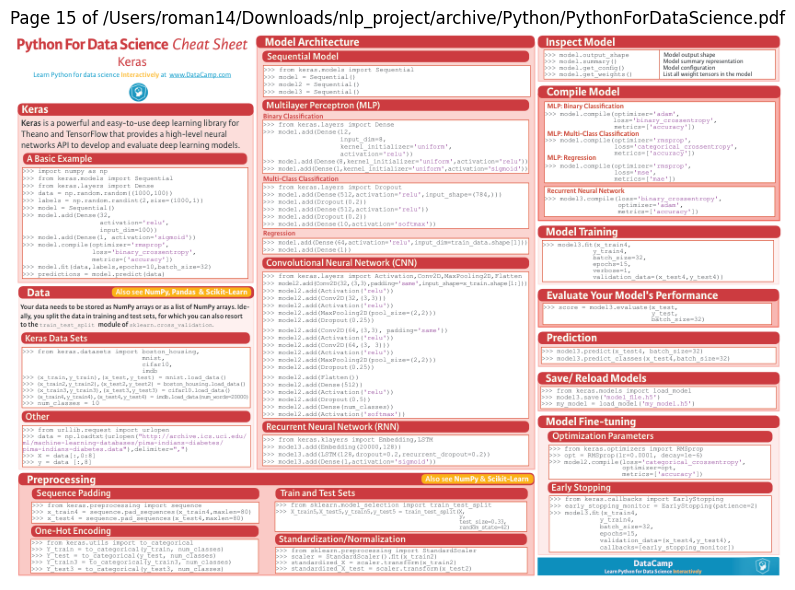

In [3]:
response = chains.invoke({"input": "Bring a basic Keras example code."})
print("Answer:", response["answer"])

file_path = response['context'][0].metadata.get('source', 'File path not found')
page_number = response['context'][0].metadata.get('page', 'Page number not found')

display_pdf_page(file_path, page_number)